# HW8

Name: Xulai Wu <br>
Github Username: LukeWu5121 <br>
USC ID: 6591102106

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import zero_one_loss
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay

## 1. Supervised, Semi-Supervised, and Unsupervised Learning

In [27]:
df = pd.read_csv('../Data/wdbc.data', header=None)
df.columns = ['ID', 'Diagnosis'] + [f'feature_{i}' for i in range(30)]

X = df.iloc[:, 2:].values
y = LabelEncoder().fit_transform(df.iloc[:, 1])  

M = 30

### b.i)

In [28]:
def get_best_model():
    pipe = make_pipeline(
        StandardScaler(),
        GridSearchCV(
            LinearSVC(penalty='l1', dual=False, max_iter=10000),
            param_grid={'C': [0.1, 1, 10]},
            cv=5,
            scoring='accuracy',
            n_jobs=-1
        )
    )
    return pipe

In [29]:
metrics_train = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
metrics_test = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}

for run in range(M):
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=run
    )

    model = get_best_model()
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    y_train_score = model.decision_function(X_train)
    y_test_score = model.decision_function(X_test)


    for name, y_true, y_pred, y_prob, target in [
        (metrics_train, y_train, y_train_pred, None, 'train'),
        (metrics_test, y_test, y_test_pred, y_test_score, 'test')
    ]:
        name['accuracy'].append(accuracy_score(y_true, y_pred))
        name['precision'].append(precision_score(y_true, y_pred))
        name['recall'].append(recall_score(y_true, y_pred))
        name['f1'].append(f1_score(y_true, y_pred))
        if y_prob is not None:
            name['auc'].append(roc_auc_score(y_true, y_prob))

=== Train Set Average ===
Accuracy: 0.9875
Precision: 0.9922
Recall: 0.9743
F1: 0.9832
Auc: nan
=== Test Set Average ===
Accuracy: 0.9658
Precision: 0.9712
Recall: 0.9357
F1: 0.9527
Auc: 0.9926


C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


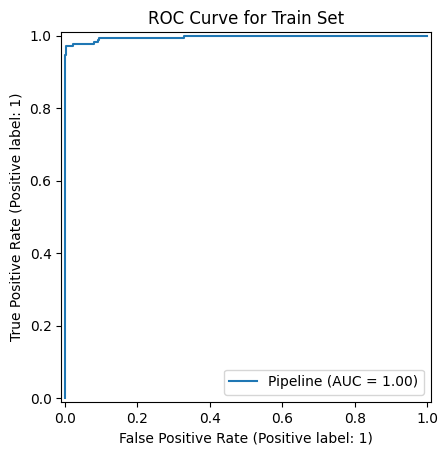

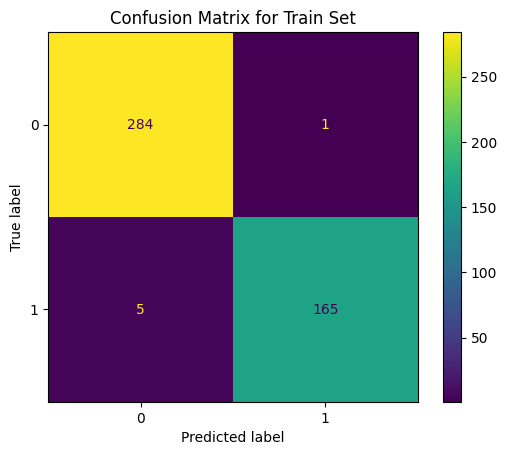

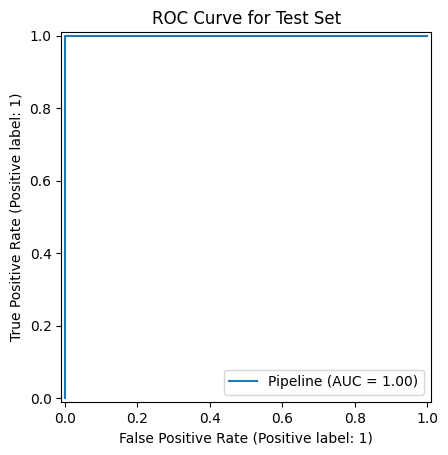

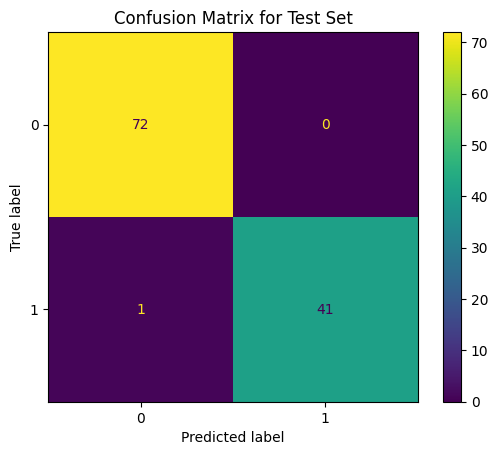

In [30]:
print("=== Train Set Average ===")
for metric in metrics_train:
    print(f"{metric.capitalize()}: {np.mean(metrics_train[metric]):.4f}")

print("=== Test Set Average ===")
for metric in metrics_train:
    print(f"{metric.capitalize()}: {np.mean(metrics_test[metric]):.4f}")

RocCurveDisplay.from_estimator(model, X_train, y_train)
plt.title("ROC Curve for Train Set")
plt.show()

ConfusionMatrixDisplay.from_estimator(model, X_train, y_train)
plt.title("Confusion Matrix for Train Set")
plt.show()

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve for Test Set")
plt.show()

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title("Confusion Matrix for Test Set")
plt.show()

### b.ii).

In [31]:
metrics_train = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
metrics_test = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}

for run in range(M):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=run
    )

    X_pos = X_train[y_train == 1]
    X_neg = X_train[y_train == 0]
    y_pos = y_train[y_train == 1]
    y_neg = y_train[y_train == 0]

    n_pos_half = len(X_pos) // 2
    n_neg_half = len(X_neg) // 2

    X_lab = np.vstack((X_pos[:n_pos_half], X_neg[:n_neg_half]))
    y_lab = np.hstack((y_pos[:n_pos_half], y_neg[:n_neg_half]))

    X_unlab = np.vstack((X_pos[n_pos_half:], X_neg[n_neg_half:]))
    y_unlab_true = np.hstack((y_pos[n_pos_half:], y_neg[n_neg_half:]))

    grid = GridSearchCV(
        LinearSVC(penalty='l1', dual=False, max_iter=10000),
        param_grid={'C': [0.01, 0.1, 1, 10, 100]},
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    pipe_cv = make_pipeline(StandardScaler(), grid)
    pipe_cv.fit(X_lab, y_lab)
    best_C = grid.best_params_['C']

    
    while len(X_unlab) > 0:
        model = make_pipeline(StandardScaler(), LinearSVC(penalty='l1', C=best_C, dual=False, max_iter=10000))
        model.fit(X_lab, y_lab)

        scores = model.decision_function(X_unlab)
        idx = np.argmax(np.abs(scores))
        pseudo_label = model.predict(X_unlab[idx].reshape(1, -1))[0]

        
        X_lab = np.vstack((X_lab, X_unlab[idx]))
        y_lab = np.hstack((y_lab, pseudo_label))

        X_unlab = np.delete(X_unlab, idx, axis=0)
        y_unlab_true = np.delete(y_unlab_true, idx, axis=0)

    
    final_model = make_pipeline(StandardScaler(), LinearSVC(penalty='l1', C=best_C, dual=False, max_iter=10000))
    final_model.fit(X_lab, y_lab)

    y_train_pred = final_model.predict(X_train)
    y_test_pred = final_model.predict(X_test)
    y_train_score = final_model.decision_function(X_train)
    y_test_score = final_model.decision_function(X_test)

    for name, y_t, y_p, y_s, store in [
        ('train', y_train, y_train_pred, y_train_score, metrics_train),
        ('test', y_test, y_test_pred, y_test_score, metrics_test)
    ]:
        store['accuracy'].append(accuracy_score(y_t, y_p))
        store['precision'].append(precision_score(y_t, y_p))
        store['recall'].append(recall_score(y_t, y_p))
        store['f1'].append(f1_score(y_t, y_p))
        store['auc'].append(roc_auc_score(y_t, y_s))

=== Train Set Average ===
Accuracy: 0.9768
Precision: 0.9814
Recall: 0.9563
F1: 0.9685
Auc: 0.9949

=== Test Set Average ===
Accuracy: 0.9596
Precision: 0.9626
Recall: 0.9278
F1: 0.9442
Auc: 0.9897


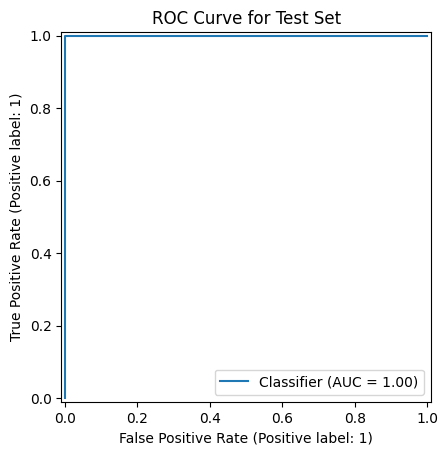

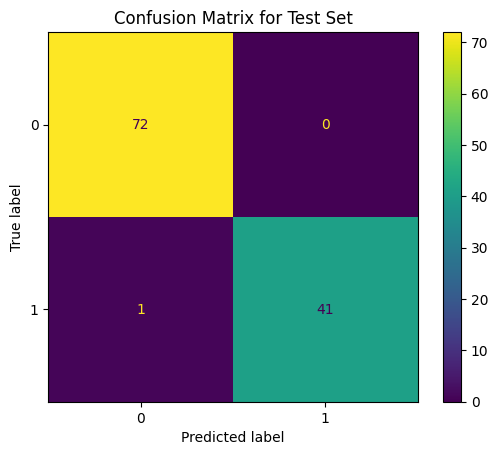

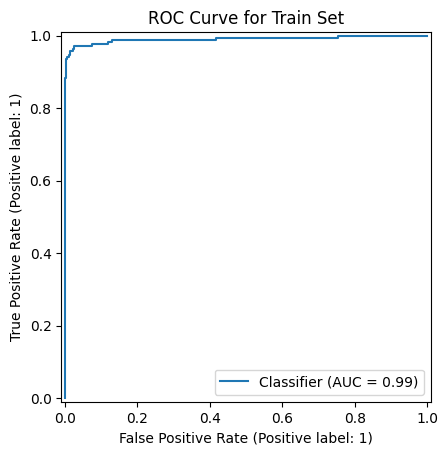

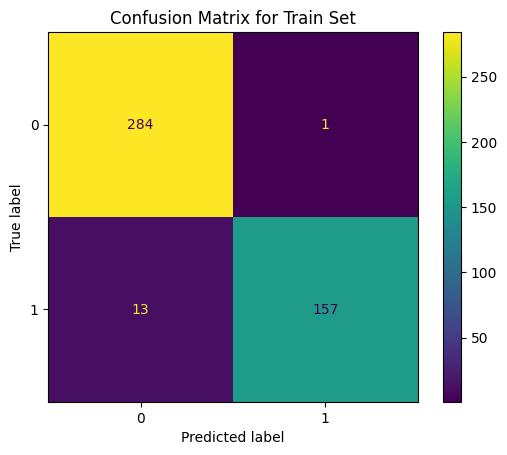

In [32]:
print("=== Train Set Average ===")
for metric in metrics_train:
    print(f"{metric.capitalize()}: {np.mean(metrics_train[metric]):.4f}")

print("\n=== Test Set Average ===")
for metric in metrics_test:
    print(f"{metric.capitalize()}: {np.mean(metrics_test[metric]):.4f}")

RocCurveDisplay.from_predictions(y_test, y_test_score)
plt.title("ROC Curve for Test Set")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.title("Confusion Matrix for Test Set")
plt.show()

RocCurveDisplay.from_predictions(y_train, y_train_score)
plt.title("ROC Curve for Train Set")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.title("Confusion Matrix for Train Set")
plt.show()

### b.iii).

In [33]:
metrics_train = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
metrics_test = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}

In [34]:
for run in range(M):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=run
    )


    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=run)
    cluster_labels = kmeans.fit_predict(X_train_scaled)
    centers = kmeans.cluster_centers_

    def assign_cluster_labels(X_data, y_true, kmeans, k=30):
        from sklearn.neighbors import NearestNeighbors
        cluster_centers = kmeans.cluster_centers_
        predicted_labels = np.zeros(len(X_data), dtype=int)

        cluster_to_label = {}

        for i in range(2):  
            distances = np.linalg.norm(X_data - cluster_centers[i], axis=1)
            nearest_idx = np.argsort(distances)[:k]
            nearest_true_labels = y_true[nearest_idx]
            majority_label = np.bincount(nearest_true_labels).argmax()
            cluster_to_label[i] = majority_label

       
        for i, cluster in enumerate(kmeans.labels_):
            predicted_labels[i] = cluster_to_label[cluster]

        return predicted_labels, cluster_to_label

    y_train_pred, label_map = assign_cluster_labels(X_train_scaled, y_train, kmeans)

    distances = np.linalg.norm(X_test_scaled[:, np.newaxis] - centers, axis=2)
    closest_clusters = np.argmin(distances, axis=1)
    y_test_pred = np.array([label_map[c] for c in closest_clusters])

    y_test_score = -np.min(distances, axis=1)  


    for name, y_t, y_p, y_s, store in [
        ('train', y_train, y_train_pred, None, metrics_train),
        ('test', y_test, y_test_pred, y_test_score, metrics_test)
    ]:
        store['accuracy'].append(accuracy_score(y_t, y_p))
        store['precision'].append(precision_score(y_t, y_p))
        store['recall'].append(recall_score(y_t, y_p))
        store['f1'].append(f1_score(y_t, y_p))
        if y_s is not None:
            store['auc'].append(roc_auc_score(y_t, y_s))

=== Train Set Average ===
Accuracy: 0.9104
Precision: 0.9241
Recall: 0.8286
F1: 0.8736
Auc: nan
=== Test Set Average ===
Accuracy: 0.9058
Precision: 0.9098
Recall: 0.8278
F1: 0.8656
Auc: 0.2662


C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


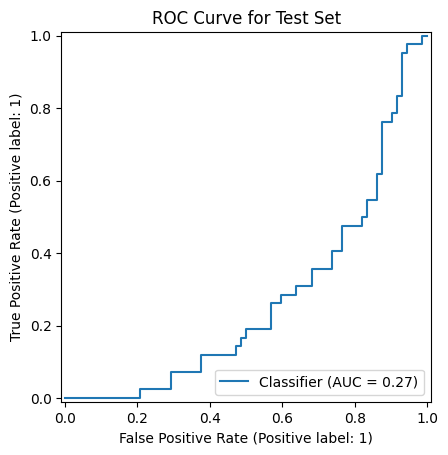

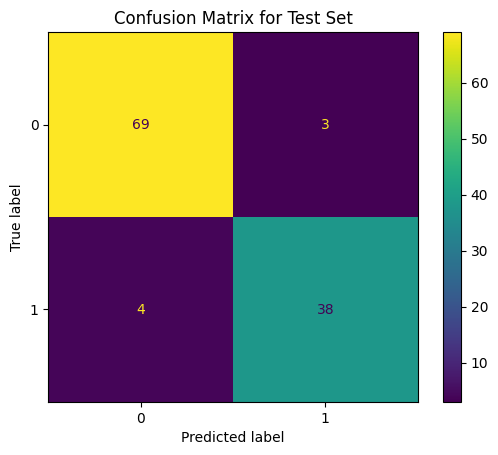

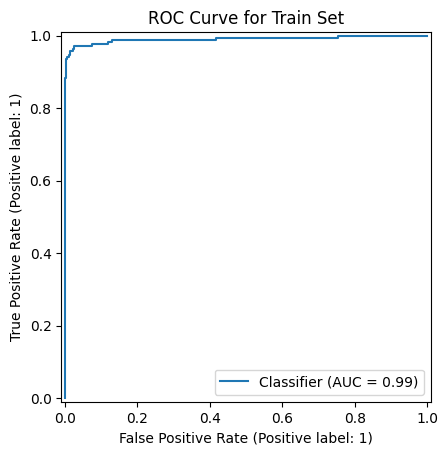

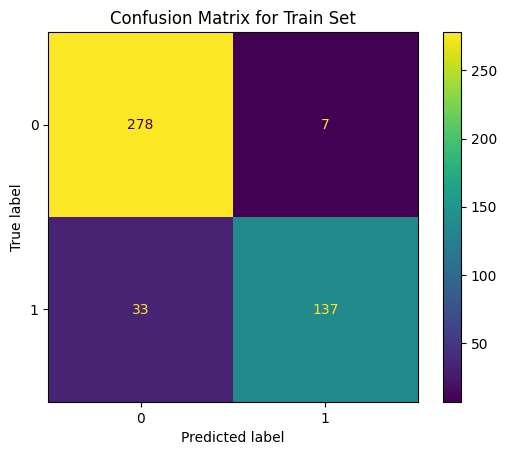

In [35]:
print("=== Train Set Average ===")
for metric in metrics_train:
    print(f"{metric.capitalize()}: {np.mean(metrics_train[metric]):.4f}")
print("=== Test Set Average ===")
for metric in metrics_test:
    print(f"{metric.capitalize()}: {np.mean(metrics_test[metric]):.4f}")

RocCurveDisplay.from_predictions(y_test, y_test_score)
plt.title("ROC Curve for Test Set")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.title("Confusion Matrix for Test Set")
plt.show()

RocCurveDisplay.from_predictions(y_train, y_train_score)
plt.title("ROC Curve for Train Set")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.title("Confusion Matrix for Train Set")
plt.show()

### b.iv).

In [36]:
metrics_train = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
metrics_test = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}

In [37]:
for run in range(M):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=run
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # === Spectral Clustering 训练 ===
    spectral = SpectralClustering(
        n_clusters=2, affinity='rbf', gamma=1.0, assign_labels='kmeans', random_state=run
    )
    cluster_labels = spectral.fit_predict(X_train_scaled)

    # === 映射聚类到标签（用每个 cluster 中所有点多数投票） ===
    def assign_cluster_labels(y_true, cluster_labels):
        cluster_to_label = {}
        for cluster_id in np.unique(cluster_labels):
            true_labels = y_true[cluster_labels == cluster_id]
            majority_label = np.bincount(true_labels).argmax()
            cluster_to_label[cluster_id] = majority_label
        predicted_labels = np.array([cluster_to_label[cid] for cid in cluster_labels])
        return predicted_labels, cluster_to_label

    y_train_pred, label_map = assign_cluster_labels(y_train, cluster_labels)

    test_clusters = spectral.fit(X_train_scaled).fit_predict(X_test_scaled)
    y_test_pred = np.array([label_map[c] for c in test_clusters])


    from sklearn.metrics.pairwise import euclidean_distances
    cluster_centers = []
    for i in np.unique(cluster_labels):
        cluster_centers.append(X_train_scaled[cluster_labels == i].mean(axis=0))
    cluster_centers = np.array(cluster_centers)

    dist_train = euclidean_distances(X_train_scaled, cluster_centers)
    dist_test = euclidean_distances(X_test_scaled, cluster_centers)
    y_train_score = -np.min(dist_train, axis=1)
    y_test_score = -np.min(dist_test, axis=1)

    for name, y_t, y_p, y_s, store in [
        ('train', y_train, y_train_pred, y_train_score, metrics_train),
        ('test', y_test, y_test_pred, y_test_score, metrics_test),
    ]:
        store['accuracy'].append(accuracy_score(y_t, y_p))
        store['precision'].append(precision_score(y_t, y_p))
        store['recall'].append(recall_score(y_t, y_p))
        store['f1'].append(f1_score(y_t, y_p))
        if y_s is not None:
            store['auc'].append(roc_auc_score(y_t, y_s))

C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: Unde

=== Train Set Average ===
Accuracy: 0.6295
Precision: 0.9000
Recall: 0.0084
F1: 0.0167
Auc: 0.2966
=== Test Set Average ===
Accuracy: 0.6225
Precision: 0.7007
Recall: 0.0421
F1: 0.0679
Auc: 0.2984


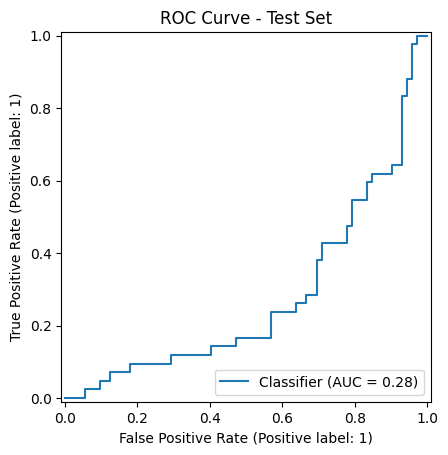

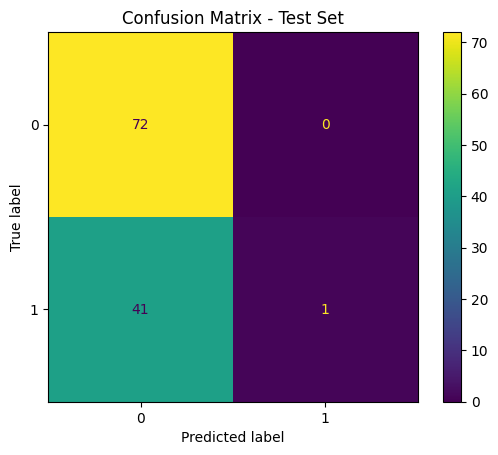

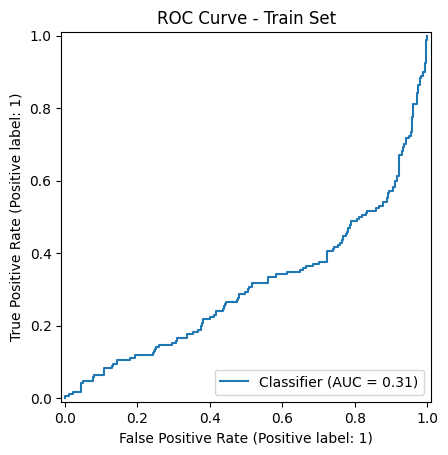

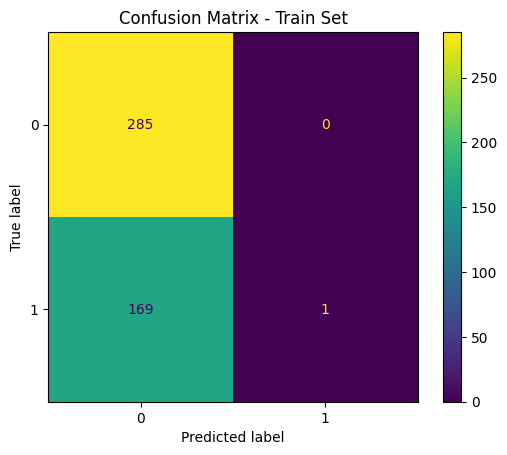

In [38]:
print("=== Train Set Average ===")
for metric in metrics_train:
    print(f"{metric.capitalize()}: {np.mean(metrics_train[metric]):.4f}")
print("=== Test Set Average ===")
for metric in metrics_test:
    print(f"{metric.capitalize()}: {np.mean(metrics_test[metric]):.4f}")

RocCurveDisplay.from_predictions(y_test, y_test_score)
plt.title("ROC Curve - Test Set")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.title("Confusion Matrix - Test Set")
plt.show()

RocCurveDisplay.from_predictions(y_train, y_train_score)
plt.title("ROC Curve - Train Set")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.title("Confusion Matrix - Train Set")
plt.show()

### b.v).

For Supervised learning, we have a accuracy, correspond with a high AUC and other test score. 
For  Self-training, we also have a high accuracy and test auc.
However, for spectral clustering and unsupervised training, we have relatively low accuracy and even poor accuracy (for unsupervised). They both have low test auc, for unsupervised, we have a terrible f1 score.

## 2. Active Learning Using Support Vector Machines

### a).

In [39]:
data = pd.read_csv('../data/data_banknote_authentication.txt', header=None)

X = data.iloc[:, :-1].values 
y = data.iloc[:, -1].values  
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=472, random_state=42, stratify=y
)

print(f"Train set size: {len(X_train)}")  
print(f"Test set size: {len(X_test)}")    

Train set size: 900
Test set size: 472


### b.i).

In [40]:
M = 50  
step = 10
train_size = 900
test_errors = np.zeros((M, train_size // step))
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

for run in range(M):
    idx = np.random.permutation(train_size)
    X_shuffled = X_train[idx]
    y_shuffled = y_train[idx]
    
    for i in range(1, train_size // step + 1):
        k = i * step  
        X_sub = X_shuffled[:k]
        y_sub = y_shuffled[:k]
        
        pipe = make_pipeline(StandardScaler(), 
                             GridSearchCV(
                                 LinearSVC(penalty='l1', dual=False, max_iter=10000),
                                 param_grid={'C': [0.01, 0.1, 1, 10, 100]},
                                 cv=5, scoring='accuracy', n_jobs=-1
                             ))
        pipe.fit(X_sub, y_sub)
        
        # === Evaluate test error ===
        y_test_pred = pipe.predict(X_test)
        test_error = 1 - accuracy_score(y_test, y_test_pred)
        test_errors[run, i-1] = test_error
test_errors_bi = test_errors  

C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-

### b.ii).

In [43]:
M = 50  # Monte Carlo runs
step = 10
test_errors_all_runs = []

for run in range(M):
    np.random.seed(run)
    pos_idx = np.where(y_train == 1)[0]
    neg_idx = np.where(y_train == 0)[0]
    init_pos = np.random.choice(pos_idx, 5, replace=False)
    init_neg = np.random.choice(neg_idx, 5, replace=False)
    initial_indices = np.concatenate([init_pos, init_neg])

    X_labeled = X_train[initial_indices]
    y_labeled = y_train[initial_indices]
    X_pool = np.delete(X_train, initial_indices, axis=0)
    y_pool = np.delete(y_train, initial_indices, axis=0)

    train_X = X_labeled.copy()
    train_y = y_labeled.copy()
    remain_X = X_pool.copy()
    remain_y = y_pool.copy()

    test_errors = []
    max_size = len(X_train)

    while len(train_X) <= max_size:
        grid = GridSearchCV(
            LinearSVC(penalty='l1', dual=False, max_iter=10000),
            param_grid={'C': [0.01, 0.1, 1, 10, 100]},
            scoring='accuracy',
            cv=5,
            n_jobs=-1
        )
        pipe = make_pipeline(StandardScaler(), grid)
        pipe.fit(train_X, train_y)
        best_C = grid.best_params_['C']

      
        model = make_pipeline(
            StandardScaler(),
            LinearSVC(penalty='l1', dual=False, C=best_C, max_iter=10000)
        )
        model.fit(train_X, train_y)

        
        test_pred = model.predict(X_test)
        test_error = zero_one_loss(y_test, test_pred)
        test_errors.append(test_error)
        if len(train_X) + step > max_size or len(remain_X) < step:
            break

    
        decision_scores = model.named_steps['linearsvc'].decision_function(remain_X)
        closest_indices = np.argsort(np.abs(decision_scores))[:step]

        train_X = np.vstack([train_X, remain_X[closest_indices]])
        train_y = np.hstack([train_y, remain_y[closest_indices]])
        remain_X = np.delete(remain_X, closest_indices, axis=0)
        remain_y = np.delete(remain_y, closest_indices, axis=0)

    test_errors_all_runs.append(test_errors)
    test_errors_bii = np.array(test_errors_all_runs)  



C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear 

## c.

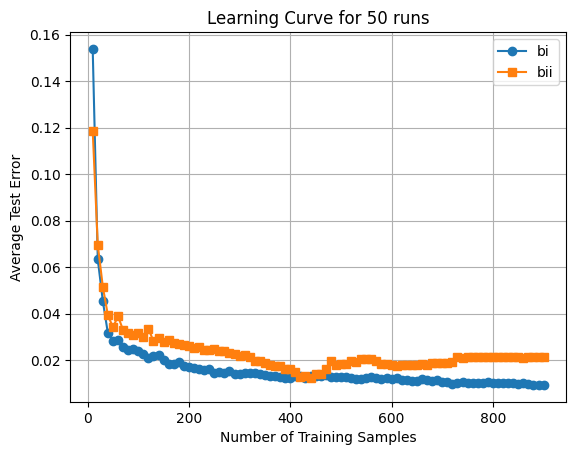

In [46]:
x_axis = np.arange(10, 901, 10)
avg_error_i = np.mean(test_errors_bi, axis=0)
avg_error_ii = np.mean(test_errors_bii, axis=0)

plt.plot(x_axis, avg_error_i, label='bi', marker='o')
plt.plot(x_axis, avg_error_ii, label='bii', marker='s')
plt.xlabel("Number of Training Samples")
plt.ylabel("Average Test Error")
plt.title("Learning Curve for 50 runs")
plt.legend()
plt.grid(True)
plt.show()